In [1]:
import torch 
import numpy as np
from PIL import Image
# pytorch=1.7.1
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
# pip install opencv-python
import cv2
import os
import matplotlib.pyplot as plt

class RawVideoExtractorCV2():
    def __init__(self, centercrop=False, size=224, framerate=-1, ):
        self.centercrop = centercrop
        self.size = size
        self.framerate = framerate
        self.transform = self._transform(self.size)

    def _transform(self, n_px):
        return Compose([
            Resize(n_px, interpolation=Image.BICUBIC),
            CenterCrop(n_px),
            lambda image: image.convert("RGB"),
            ToTensor(),
            #Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ])

    def video_to_tensor(self, video_file, preprocess, sample_fp=0, start_time=None, end_time=None):
        if start_time is not None or end_time is not None:
            assert isinstance(start_time, int) and isinstance(end_time, int) \
                   and start_time > -1 and end_time > start_time
        assert sample_fp > -1

        # Samples a frame sample_fp X frames.
        cap = cv2.VideoCapture(video_file)
        
        frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        #print(frameCount,fps)

        total_duration = (frameCount + fps - 1) // fps
        start_sec, end_sec = 0, total_duration

        if start_time is not None:
            start_sec, end_sec = start_time, end_time if end_time <= total_duration else total_duration
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(start_time * fps))

        interval = 1
        if sample_fp > 0:
            interval = fps // sample_fp
        else:
            sample_fp = fps
        if interval == 0: interval = 1

        inds = [ind for ind in np.arange(0, fps, interval)]
        assert len(inds) >= sample_fp
        inds = inds[:sample_fp]

        ret = True
        images, included = [], []

        for sec in np.arange(start_sec, end_sec + 1):
            if not ret: break
            sec_base = int(sec * fps)
            for ind in inds:
                cap.set(cv2.CAP_PROP_POS_FRAMES, sec_base + ind)
                ret, frame = cap.read()
                if not ret: break
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                images.append(preprocess(Image.fromarray(frame_rgb).convert("RGB")))

        cap.release()

        if len(images) > 0:
            video_data = torch.tensor(np.stack(images))
        else:
            video_data = torch.zeros(1)
        return {'video': video_data}

    def get_video_data(self, video_path, start_time=None, end_time=None):
        image_input = self.video_to_tensor(video_path, self.transform, sample_fp=self.framerate, start_time=start_time, end_time=end_time)
        return image_input

    def process_raw_data(self, raw_video_data):
        tensor_size = raw_video_data.size()
        tensor = raw_video_data.view(-1, 1, tensor_size[-3], tensor_size[-2], tensor_size[-1])
        return tensor

    def process_frame_order(self, raw_video_data, frame_order=0):
        # 0: ordinary order; 1: reverse order; 2: random order.
        if frame_order == 0:
            pass
        elif frame_order == 1:
            reverse_order = np.arange(raw_video_data.size(0) - 1, -1, -1)
            raw_video_data = raw_video_data[reverse_order, ...]
        elif frame_order == 2:
            random_order = np.arange(raw_video_data.size(0))
            np.random.shuffle(random_order)
            raw_video_data = raw_video_data[random_order, ...]

        return raw_video_data

# An ordinary video frame extractor based CV2
RawVideoExtractor = RawVideoExtractorCV2



In [ ]:
import cv2
video_path = '/data1/ckli/MSRVTT/MSRVTT_Videos/video12.mp4'
cap = cv2.VideoCapture(video_path)

ret,frame = cap.read()
cv2.imshow('video12',frame)
cv2.waitKey(1)
    

10 torch.Size([3, 224, 224])


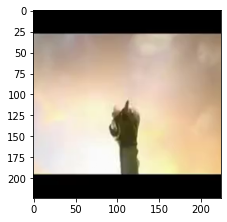

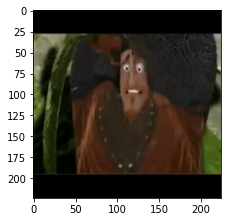

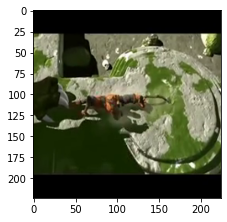

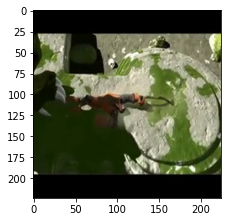

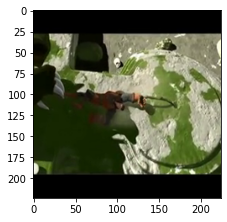

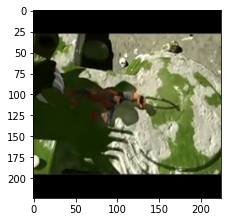

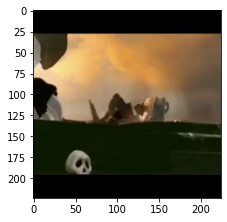

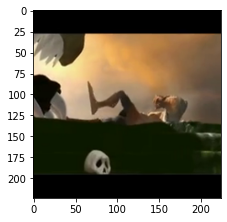

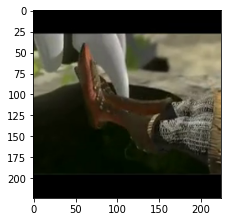

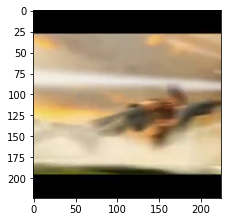

In [112]:
testExtractor = RawVideoExtractorCV2(framerate=1)
video_path = '/data1/ckli/MSRVTT/MSRVTT_Videos/video9208.mp4'
image_input = testExtractor.get_video_data(video_path,start_time=0,end_time=10)
for i in range(len(image_input['video'])):
    frame = image_input['video'][i].numpy()
    frame = frame.transpose(1,2,0)
    plt.figure(figsize=(20,20))
    plt.subplot(5,5,i+1)
    plt.imshow(frame,)

print(len(image_input['video']),(image_input['video'][1].shape))


In [113]:
import torch.nn as nn
class PicNet(nn.Module):
    def __init__(self,channel=3):
        super().__init__()
        self.channel = channel
        self.pool = nn.AvgPool2d(kernel_size=(4,4),stride=(4,4))
    def forward(self,x):
        return self.pool(x)
net = PicNet()

frame_list = []
length_list = []

for i in range(len(image_input['video'])):
    if i==0:
        frame_list.append(image_input['video'][i])
        l = 1
    else:
        k = net(image_input['video'][i]).sum()/net(image_input['video'][i-1]).sum()
        diff = net(image_input['video'][i])/k-net(image_input['video'][i-1])
        #diff = image_input['video'][i]-image_input['video'][i-1]
        print(i,i-1,torch.sum(diff*diff).item())
        if torch.sum(diff*diff).item() > 500:
            frame_list.append(image_input['video'][i])
            length_list.append(l)
            l = 1
        else:
            l += 1
            if i==len(image_input['video'])-1:
                length_list.append(l)
print(len(length_list),length_list)
            
    
    
    

1 0 2076.45361328125
2 1 153.19598388671875
3 2 199.19845581054688
4 3 183.1336669921875
5 4 205.14132690429688
6 5 1182.5164794921875
7 6 151.8161163330078
8 7 525.6941528320312
9 8 368.49822998046875
4 [1, 5, 2, 2]


In [78]:
frame_5=image_input['video'][5]
frame_6=image_input['video'][6]
frame_7=image_input['video'][7]
print((frame_7/frame_6).sum().item())
k = frame_7.sum()/frame_6.sum()
diff=frame_7/k-frame_6
#print(diff)
print(torch.sum(diff*diff).item())

nan
1346.5283203125


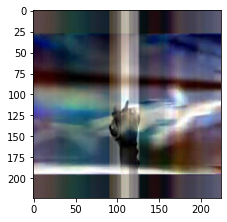

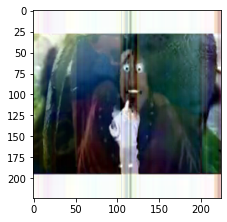

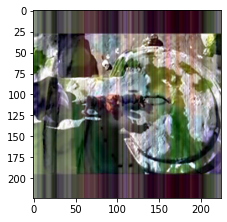

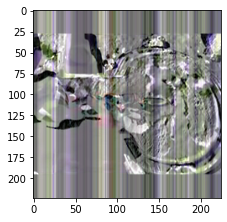

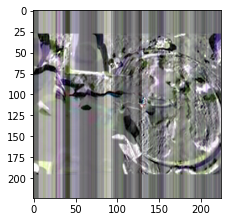

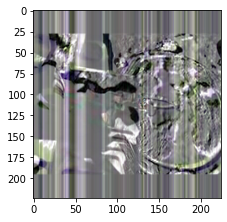

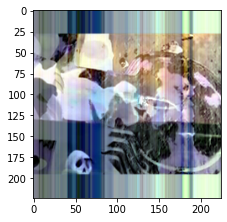

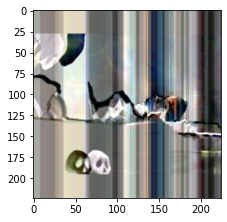

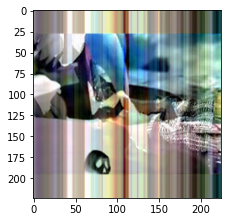

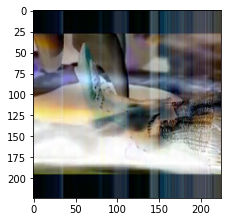

In [114]:
def maxminnorm(array):
    maxcols=array.max(axis=0)
    mincols=array.min(axis=0)
    data_shape = array.shape
    data_rows = data_shape[0]
    data_cols = data_shape[1]
    t=np.empty((data_rows,data_cols))
    for i in range(data_cols):
        t[:,i]=(array[:,i]-mincols[i])/(maxcols[i]-mincols[i])
    return t

for i in range(len(image_input['video'])):
    diff = image_input['video'][i]-image_input['video'][i-1]
    frame = diff.numpy()
    frame = frame.transpose(1,2,0)
    
    frame[:,:,0] = maxminnorm(frame[:,:,0])
    frame[:,:,1] = maxminnorm(frame[:,:,1])
    frame[:,:,2] = maxminnorm(frame[:,:,2])
    plt.figure(figsize=(20,20))
    plt.subplot(5,5,i+1)
    plt.imshow(frame,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

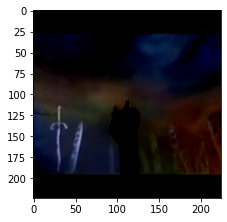

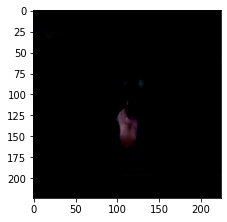

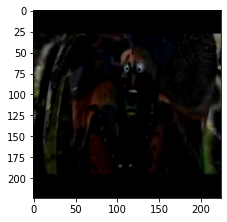

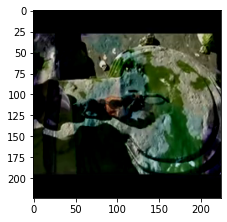

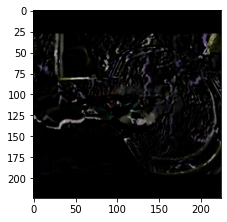

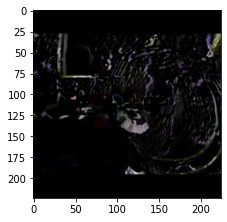

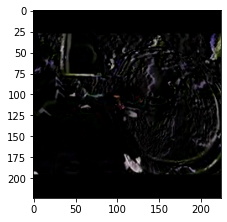

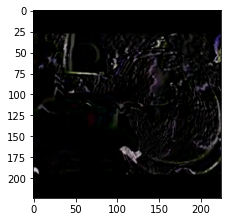

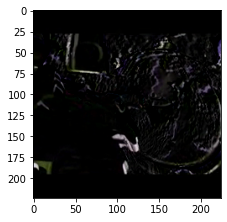

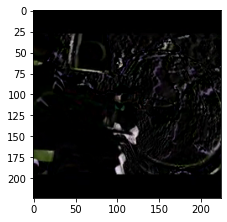

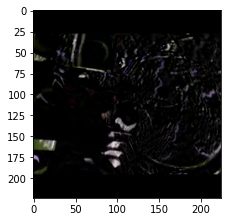

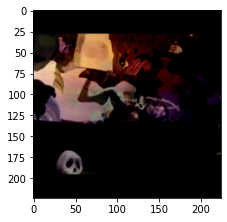

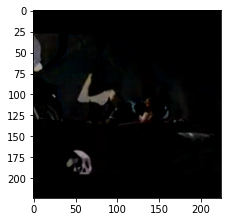

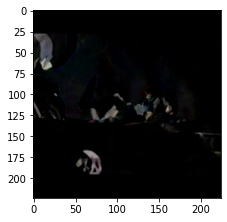

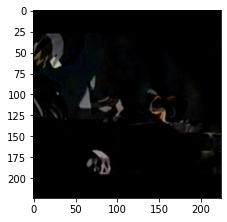

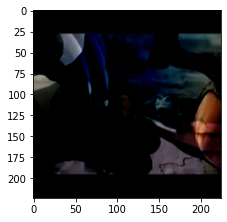

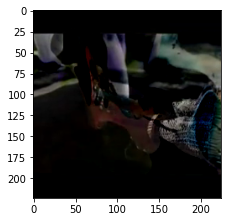

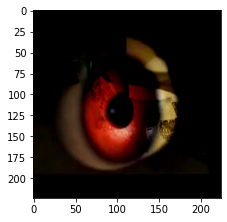

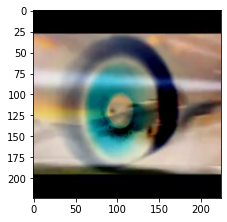

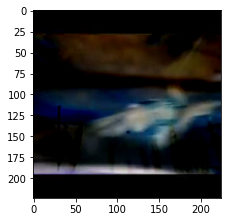

In [111]:
for i in range(len(image_input['video'])):
    diff = image_input['video'][i]-image_input['video'][i-1]
    frame = diff.numpy()
    frame = frame.transpose(1,2,0)
    
    #frame[:,:,0] = maxminnorm(frame[:,:,0])
    #frame[:,:,1] = maxminnorm(frame[:,:,1])
    #frame[:,:,2] = maxminnorm(frame[:,:,2])
    plt.figure(figsize=(20,20))
    plt.subplot(5,5,i+1)
    plt.imshow(frame,)

In [93]:
#通过尺寸放缩来减轻空间位置上细微移动的影响
import torch.nn as nn
class PicNet(nn.Module):
    def __init__(self,channel=3):
        super().__init__()
        self.channel = channel
        self.pool = nn.AvgPool2d(kernel_size=(4,4),stride=(4,4))
    def forward(self,x):
        return self.pool(x)
net = PicNet()
frames = torch.stack((frame_5,frame_6,frame_7),dim=0)
frms = net(frames)
print(frames.size(),frms.shape)
f5=frms[0]
f6=frms[1]
f7=frms[2]
diff=f7-f6
print(torch.sum(diff*diff).item())
        
        

torch.Size([3, 3, 224, 224]) torch.Size([3, 3, 56, 56])
60.661808013916016
